In [1]:
from voc_data_loader import image_loader, voc_meta
%matplotlib inline

from models import rpn, resnet, rpn_utils, training_params

import matplotlib
import numpy
import matplotlib.pyplot as plt

In [2]:
loader = image_loader("./")
meta = voc_meta("./")

In [18]:
batch_size = 1
data, labels, boxes = loader.get_next_train_batch(batch_size, mode="class")

This is the data image shape

In [8]:
print data.shape

(1, 512, 512, 3)


Here is what the bounding boxes look like

In [19]:
print boxes

[[[ 153.  277.  189.  296.]
  [ 139.  311.  195.  380.]
  [ 196.  287.  263.  380.]
  [  14.  292.   92.  381.]
  [ 103.  289.  248.  381.]
  [  76.  180.  111.  252.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]]]


And lastly, here are the labels (one-hot format):

In [20]:
print labels

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.
   0.  0.]]


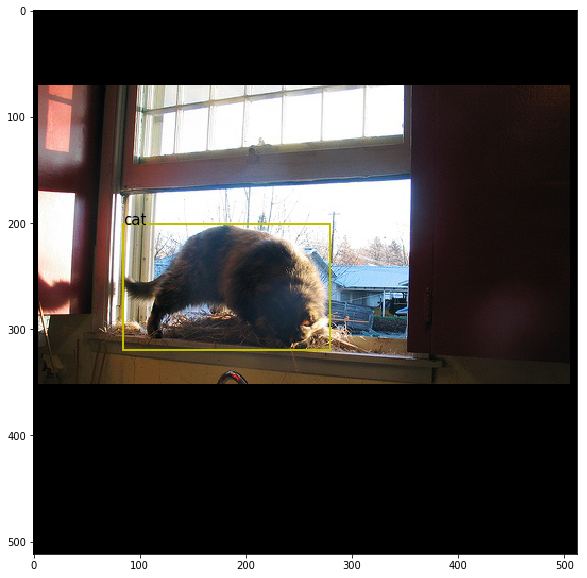

In [7]:
for i in range(batch_size):
    n_roi = int(numpy.sum(labels[i]))
    fig,ax = plt.subplots(figsize=(10,10))
    plt.imshow(data[i])
    for box, label in zip(boxes[i, 0:n_roi], labels[i, 0:n_roi]):
        class_name = meta.class_name(numpy.argmax(label))
        rect = matplotlib.patches.Rectangle((box[0],box[1]),
                                            box[2] - box[0],
                                            box[3] - box[1],
                                            linewidth=2,
                                            edgecolor='y',
                                            facecolor='none')
        ax.text(box[0], box[1],class_name, fontsize=15)
        ax.add_patch(rect)
    plt.show()


Now set up the tensorflow interface to do forward pass prediction

In [8]:
import tensorflow as tf
import numpy


Define parameters for the convolutional network and the RPN:

In [9]:

# Use a resnet for the convolutional step:
conv_params = resnet.resnet_params()
conv_params.network_params()['n_blocks'] = 8
conv_params.network_params()['include_final_classifier'] = False
conv_params.network_params()['n_classes'] = 10
conv_params.network_params()['n_initial_filters'] = 12
conv_params.network_params()['downsample_interval'] = 2
conv_params.network_params()['initial_stride'] = 2
conv_params.network_params()['initial_kernel'] = 5
conv_params.network_params()['bottleneck'] = False
conv_params.network_params()['weight_decay'] = 1E-3
conv_params.network_params()['activation'] = 'softmax'


# Set up the network we want to test:
rpn_params = rpn.rpn_params()
rpn_params.network_params()['n_anchors_per_box'] = 9
rpn_params.network_params()['weight_decay'] = 1E-3
rpn_params.network_params()['n_selected_regressors'] = 56

LOGDIR="logs/rpn_resnet/rpn/"

Next, set up the trained network:

In [10]:
# Set up the graph:

N_MAX_TRUTH = 10
# Set input data and label for training
data_tensor = tf.placeholder(tf.float32, [1, 512,512,3], name='x')
label_tensor = tf.placeholder(tf.float32, [N_MAX_TRUTH, 20], name='labels')
box_label = tf.placeholder(tf.float32, [N_MAX_TRUTH, 4], name='truth_anchors')

# Let the convolutional part of the network be independant
# of the classifiers:

conv_net = resnet.resnet(conv_params)
final_conv_layer = conv_net.build_network(input_tensor=data_tensor,
                                          is_training=True)    

RPN = rpn.rpn(rpn_params)
classifier, regressor = RPN.build_rpn(final_conv_layer=final_conv_layer, 
                                          is_training=True)

# The previous functions work with batch_size == 1 to allow interface with
# other code, particularly for the conv nets.
# 
# Here, squeeze the batch size out to get just the raw shapes:
classifier = tf.squeeze(classifier)
regressor = tf.squeeze(regressor)

# Get a set of reference anchors:

n_anchors_x = final_conv_layer.get_shape().as_list()[1]
n_anchors_y = final_conv_layer.get_shape().as_list()[2]
effective_stride_x = data_tensor.get_shape().as_list()[1] / n_anchors_x
effective_stride_y = data_tensor.get_shape().as_list()[2] / n_anchors_y
n_anchors_x -= 2
n_anchors_y -= 2

_base_anchors = rpn_utils.generate_anchors(base_size = 16*3, 
                                           ratios = [0.5, 1, 2.0], 
                                           scales = [2,4,6])

_anchors = rpn_utils.pad_anchors(_base_anchors,
                                n_tiles_x=n_anchors_x, 
                                n_tiles_y=n_anchors_y, 
                                step_size_x=effective_stride_x, 
                                step_size_y=effective_stride_y)

rpn_utils.boxes_whctrs_to_minmax(_anchors, in_place=True)

    
    

array([[ -10. ,  -44. ,   58. ,   92. ],
       [ -24. ,  -24. ,   72. ,   72. ],
       [ -44. ,  -10. ,   92. ,   58. ],
       ..., 
       [ 386. ,  284.5,  590. ,  691.5],
       [ 344. ,  344. ,  632. ,  632. ],
       [ 284.5,  386. ,  691.5,  590. ]], dtype=float32)

Restore the network:

In [11]:
sess = tf.InteractiveSession()        
latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
print latest_checkpoint
saver = tf.train.Saver()
saver.restore(sess, latest_checkpoint)

logs/rpn_resnet/rpn//checkpoints/save-5000
INFO:tensorflow:Restoring parameters from logs/rpn_resnet/rpn//checkpoints/save-5000


Run a forward pass of the network:

In [12]:
data, labels, boxes = loader.get_next_train_batch(1)
labels = numpy.squeeze(labels)
boxes = numpy.squeeze(boxes)
cls, rgs = sess.run(
                [classifier, regressor], 
                feed_dict={data_tensor : data,
                           label_tensor : labels,
                           box_label : boxes,
                           # regressor : _fake_regressor, 
#                            anchors : _anchors
                          })
print cls.shape
print rgs.shape
data = numpy.squeeze(data)

(8100, 2)
(8100, 4)


In [28]:
pos_indexes = numpy.where(cls[:,1] > 0.99999)[0]
pos_boxes = rgs[pos_indexes]
pos_anchors = _anchors[pos_indexes]
print pos_indexes
print pos_anchors
print pos_boxes

[1459 1517 1698 1847 1909 1937 2329]
[[  56.   168.   152.   264. ]
 [ -32.   244.   240.   380. ]
 [  18.   -51.5  222.   355.5]
 [  52.   390.   188.   458. ]
 [  88.     8.   184.   104. ]
 [  68.    70.   204.   138. ]
 [   8.   168.   296.   456. ]]
[[  8.92144871   7.85317755  11.32084656  -6.40415239]
 [-10.52096844 -10.47693253   8.43553829 -11.33213234]
 [ 11.03774643  -9.93056774   9.97866917 -11.2743187 ]
 [  8.56032085   5.46873283   8.08235359  -8.27849865]
 [ 12.02618694  12.24178219   9.7312994   10.26706505]
 [ -9.45723438   9.4018631    9.56912804  10.8996439 ]
 [  4.93354893   4.95178556   5.87555647   6.33705235]]


In [18]:
print data.shape

(512, 512, 3)


Draw the output of this forward pass:

[[  1.41206018e+03   2.24123877e+03   1.25436740e+07   4.36833441e-01]
 [ -2.55703247e+03  -3.73723438e+03   1.10590788e+06   4.55303583e-03]
 [  2.46837964e+03  -3.58181689e+03   4.78667450e+06   4.51299874e-03]
 [  1.66134033e+03   2.89467969e+03   6.08526375e+05   1.16294511e-01]
 [  2.30081836e+03   1.28114539e+03   3.09790050e+06   2.99201000e+06]
 [ -1.86127576e+03   1.36745715e+03   2.92044925e+06   7.47367600e+06]
 [  1.46833044e+03   2.42601416e+03   1.05441961e+05   2.57698391e+05]]
[[ -6.27042500e+06   2.24102026e+03   6.27324900e+06   2.24145703e+03]
 [ -5.55511000e+05  -3.73723657e+03   5.50396875e+05  -3.73723193e+03]
 [ -2.39086875e+06  -3.58181909e+03   2.39580575e+06  -3.58181470e+03]
 [ -3.02601844e+05   2.89462158e+03   3.05924531e+05   2.89473779e+03]
 [ -1.54664938e+06  -1.49472388e+06   1.55125112e+06   1.49728612e+06]
 [ -1.46208588e+06  -3.73547050e+06   1.45836338e+06   3.73820550e+06]
 [ -5.12526484e+04  -1.26423180e+05   5.41893125e+04   1.31275219e+05]]


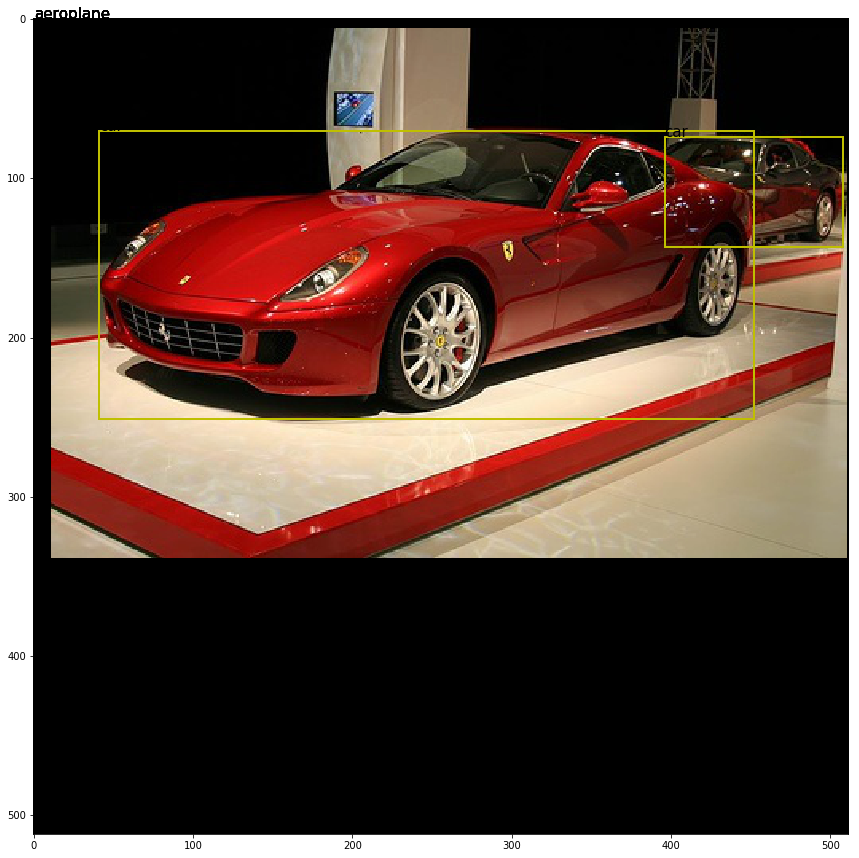

In [29]:
n_roi_true = int(numpy.sum(labels))
fig,ax = plt.subplots(figsize=(15,15))
plt.imshow(data)
for box, label in zip(boxes, labels):
    class_name = meta.class_name(numpy.argmax(label))
    rect = matplotlib.patches.Rectangle((box[0],box[1]),
                                        box[2] - box[0],
                                        box[3] - box[1],
                                        linewidth=2,
                                        edgecolor='y',
                                        facecolor='none')
    ax.text(box[0], box[1],class_name, fontsize=15)
    ax.add_patch(rect)

#Convert the boxes to xyctrs format:
pos_boxes = rpn_utils.boxes_regcoord_to_whctrs(pos_boxes, pos_anchors)
print pos_boxes
pos_boxes = rpn_utils.boxes_whctrs_to_minmax(pos_boxes)
print pos_boxes
# pos_boxes = rpn_utils.
# for box in pos_boxes:
#     rect = matplotlib.patches.Rectangle((box[0],box[1]),
#                                         box[2] - box[0],
#                                         box[3] - box[1],
#                                         linewidth=2,
#                                         edgecolor='r',
#                                         facecolor='none')
#     ax.text(box[0], box[1],class_name, fontsize=15)
#     ax.add_patch(rect)
# Draw the boxes on the image

# print cls[pos_indexes]

# Draw some boxes
    
plt.show()